In [2]:
import os
os.environ['USE_PYGEOS'] = '0'

import glob
import re
import regionmask
import datetime
# to fix MJD
import astropy
from astropy.time import Time

# data management
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon
from geospatial_functions import get_background_map

# imported from provided py code: long functions
from calc_geoid_change_alt import readstrokescoefficients, plm

In [3]:
# loading other layers
outline           = gpd.read_file(f"Data\\lena_basin_outline_polygon.gpkg",driver="GPKG")
main_rivers       = gpd.read_file(f"Data\\lena_main_river.gpkg",driver="GPKG")   
coast             = gpd.read_file(f"Data\\north_east_russian_coastlines.gpkg",driver="GPKG")   
# fixing crs
for layer in [outline,main_rivers,coast]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

background:

Grace can measure $\frac{\Delta S}{\Delta t}$, when looking at the water balance: $\frac{\Delta S}{\Delta t} = P - L$ where $L$ are the losses.

Losses are due to Evapotranspiration ($ET$), Discharge ($Q$) and Underground flow (ground water - $G$). 

Evaporation can be esimated but is difficult, discharge can be considered known: 

$\frac{\Delta S}{\Delta t} = P - Q - ET - GW$

# focus on grace data
Downloaded data can be loaded in, note using stokes coefficients till 60th

In [5]:
grace_files = glob.glob('Data\\Grace_filtered\*.gfc')
love_numbers_kl = np.loadtxt('Data\\loadLoveNumbers_60.txt')[:,1]
l = 60
m = 60

Stokes coeffcients order 1& 2 need to be handeled differently

order 1: 

In [52]:
fname_stoke_coeff1 = f'Data\\Grace\\degree1_stokes_coeff.txt'
df_stokes_1 = pd.read_csv(fname_stoke_coeff1,skiprows=116,delimiter="\s+", 
        names=['GRCOF2',"l","m", "Clm","Slm","sd_Clm","sd_Slm","begin_date","end_date"])
### drop unwanted
df_stokes_1.drop(columns=["GRCOF2","sd_Clm","sd_Slm"],inplace=True)
### Reformat dates
df_stokes_1["end_date"] = df_stokes_1.apply(lambda x: pd.Timestamp(f'{str(x.end_date)[0:4]}-{str(x.end_date)[4:6]}-{str(x.end_date)[6:8]}'),axis=1)
### dirty fix to make more fit
df_stokes_1["begin_date"] = df_stokes_1.apply(lambda x: pd.Timestamp(f'{str(x.begin_date)[0:4]}-{str(x.begin_date)[4:6]}-01'),axis=1)

In [7]:
df_1_0 = df_stokes_1[df_stokes_1['m'] == 0].set_index('begin_date')
df_1_1 = df_stokes_1[df_stokes_1['m'] == 1].set_index('begin_date')

In [8]:
# easiest way to fix the indexing in matchting the correct indexes
df_index_replace = df_1_1.index.to_numpy().copy()
for i, index in enumerate(df_1_1.index):
    if i == 0:
        pass
    if (df_1_1.index[i-1] - index) == pd.Timedelta(0):
        replace = pd.Timestamp(f'{index.year}-{index.month+1}-{index.day}')
        df_index_replace[i] = replace
df_1_1.index = df_index_replace
df_1_0.index = df_index_replace

order 2,0 & 3,0:

In [10]:
def MJD_to_ts(mjd):
    ## thanks to https://stackoverflow.com/questions/72597699/how-do-i-convert-mjdjulian-date-to-utc-using-astropy
    # Start with some time in modified julian date (MJD)
    # Convert to Julian Date
    mjd = float(mjd)
    jd = mjd + 2400000.5
    # Convert to astropy Time object
    t = astropy.time.Time(jd, format='jd')
    # Convert to datetime
    str = t.to_datetime()
    return str

In [58]:
fname_stoke_coeff2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
col_names = ['MJD begin',"Year fraction begin","C20","C20 - C20_mean (1.0E-10)","sig_C20 (1.0E-10)", 
             "C30","C30 - C30_mean (1.0E-10)","sig_C30 (1.0E-10)",'MJD end',"Year fraction end"]
df_stokes_2_3 = pd.read_csv(fname_stoke_coeff2,skiprows=37,delimiter="\s+",names=col_names)
# fix date format
df_stokes_2_3["begin_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3["end_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3 = df_stokes_2_3[["begin_date","C20","C30","end_date"]].set_index("begin_date")

# allign indexes and replace like in C_1_1..
df_stokes_2_3 = df_stokes_2_3.iloc[:-2] # remove last two months to make same length
df_stokes_2_3.index = df_index_replace

In [12]:
# Names and dates needed, obtained from file name
# grace_names = [file[-11:-4] for file in grace_files]
# times = [pd.Timestamp(grace_names_i) for grace_names_i in grace_names]

Adjust readstokescoefficients to also obtain `time_period_of_data`

In [13]:
def readstrokescoefficients_filtered(filename):
    with open(filename) as f:
        reach_end_of_head = 0
        for line in f:
            line = line.strip()
            if reach_end_of_head == 0:
                if line.startswith("earth_gravity_constant"):
                    GM = float(line[line.index(" ") + 1:])
                elif "radius" in line:
                    line = re.sub(' +', ' ', line)
                    R = float(line.split(" ")[1])
                elif line.startswith("max_degree"):
                    line = re.sub(' +', ' ', line)
                    max_degree = int(line.split(" ")[1])
                    C = np.zeros((max_degree + 1, max_degree + 1))
                    S = np.zeros((max_degree + 1, max_degree + 1))
                elif line.startswith('time_period_of_data'):
                    line = re.sub(' +', ' ', line)
                    date_line = line.split(" ")
                    begin_date = str(line.split(" ")[1])
                    begin_date_ts = pd.Timestamp(f'{begin_date[0:4]}-{begin_date[4:6]}-01')
                    mid_date = end_date = str(line.split(" ")[-1])
                    mid_date_ts = pd.Timestamp(f'{mid_date[0:4]}-{mid_date[4:6]}-{mid_date[6:8]}')
                    end_date = str(line.split(" ")[3])
                    end_date_ts = pd.Timestamp(f'{end_date[0:4]}-{end_date[4:6]}-{end_date[6:8]}')
                    date_lst = [begin_date_ts,mid_date_ts,end_date_ts]
                    
                else:
                    if line.startswith("end_of_head"):
                        reach_end_of_head = 1
            else:
                line = re.sub(' +', ' ', line)
                line = line.split()
                L = int(line[1])
                M = int(line[2])
                C[L, M] = float(line[3])
                S[L, M] = float(line[4])
    return C, S, R, GM, date_lst


In [14]:
# load in all coefficient
C, S, times, grace_names = [], [], [], []
plot_times = []
for i, file in enumerate(grace_files):
    C_i, S_i, R, GM, [begin_date_ts, mid_date_ts, end_date_ts] = readstrokescoefficients_filtered(file)
    time_i = begin_date_ts
    # replace C_1_0,C_1_1, S_1_1, C_2_0, C_3_0
    try:
        test  = df_1_0.loc[time_i,"Clm"]
        new_time = time_i
    except KeyError: # issue with finding correct value, this is easiest fix
        new_time = pd.Timestamp(f'{time_i.year}-{time_i.month-1}-{time_i.day}')
        print(new_time)
    
    C_i[1,0]  = df_1_0.loc[new_time,"Clm"]
    C_i[1,1]  = df_1_1.loc[new_time,"Clm"]
    S_i[1,1]  = df_1_1.loc[new_time,"Slm"]
    C_i[2,0]  = df_stokes_2_3.loc[new_time,"C20"]
    C_30  = df_stokes_2_3.loc[new_time,"C30"]
    if C_30 == "NaN": 
        pass
    else: 
        C_i[3,0] = C_30
        
    C.append(C_i), S.append(S_i), times.append(time_i), grace_names.append(f'{time_i.year}-{time_i.month}-{time_i.day}'), plot_times.append(mid_date_ts)

In [15]:
np.savetxt("Data\\grace_names_friendly.txt",np.array(grace_names),delimiter=" ", fmt="%s") 

In [16]:
# get differences for each pair
dc1_store = []
dc2_store = []
ds1_store = []
ds2_store = []
for i, c in enumerate(C):
    if i == 0:
        pass # first has no prev
    else:
        dc1 = C[i]   - ((C[i]    + C[i-1]) / 2)
        dc2 = C[i-1] - ((C[i-1]  + C[i]  ) / 2)
        ds1 = S[i]   - ((S[i]    + S[i-1]) / 2)
        ds2 = S[i-1] - ((S[i-1]  + S[i]  ) / 2)
        dc1_store.append(dc1), dc2_store.append(dc2) 
        ds1_store.append(ds1), ds2_store.append(ds2)

using 
\begin{equation}
\delta h_w \left(\theta,\lambda\right) = \sum_{l,m=0}^{\infty}=\bar{C_{lm}^{\delta h_w}} \bar{Y}_{lm}\left(\theta,\lambda\right)
\end{equation}


In [17]:
rho_av__rho_w = 5.5 # aprox

In [18]:
dh_c1_store = []
dh_c2_store = []
dh_s1_store = []
dh_s2_store = []

for k, dc1 in enumerate(dc1_store):
    C_dhw_i_1 = np.zeros((l+1, l+1))
    S_dhw_i_1 = np.zeros((l+1, l+1))
    C_dhw_i_2 = np.zeros((l+1, l+1))
    S_dhw_i_2 = np.zeros((l+1, l+1))
    for i in range(l+1):
        for j in range(i+1):
            multiplication_factor = (R  * (2 * i + 1) * rho_av__rho_w) / ( 3 * (1 + love_numbers_kl[i]))
            C_dhw_i_1[i, j] = (dc1_store[k][i, j] * multiplication_factor)
            S_dhw_i_1[i, j] = (ds1_store[k][i, j] * multiplication_factor)
            C_dhw_i_2[i, j] = (dc2_store[k][i, j] * multiplication_factor)
            S_dhw_i_2[i, j] = (ds2_store[k][i, j] * multiplication_factor)
    dh_c1_store.append(C_dhw_i_1), dh_c2_store.append(C_dhw_i_2) 
    dh_s1_store.append(S_dhw_i_1), dh_s2_store.append(S_dhw_i_2)

Create array of lat lon for the area: 

![Figures\Lena_Basin_map.png](Figures\Lena_Basin_map.png)

In [19]:
_lambda = np.pi/180 * np.arange(270,330,1) - np.pi # 90 - 150 # deg lon
theta = np.pi - np.pi/180 * np.arange(180-40, 180-10,1) # 80 - 50 deg lat

print('_lambda=',_lambda/np.pi*180)
print('\n')
print('theta=',theta/np.pi*180)

_lambda= [ 90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149.]


theta= [40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25. 24. 23.
 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11.]


In [20]:
# last run: 2023-10-26 09:42:55.218272 - 2023-10-26 10:39:23.874429
# fname = "Data\\anomally_waterhead_full.nc"
# fname = "Data\\anomally_waterhead_filtered_multicore.nc"
# fname = "Data\\anomally_waterhead_filtered_test2.nc" # debug
run = False
debug = False

if debug:
    n=1                       
    loop = dh_c1_store[:n]
    times = times[:(n+1)]      # debugging
    fname = "Data\\anomally_waterhead_filtered_test_multicore.nc"
else:
    loop = dh_c1_store
    fname = "Data\\anomally_waterhead_filtered_multicore.nc"
if run:
    # this is a much slower method, faster is the multicore.py which uses multi proecessing 
    store_ewh_1 = []
    store_ewh_2 = []
    print(datetime.datetime.now())
    for z, dh_c1 in enumerate(loop): # debugging
        print(f'{z=}',end='\n')
        ewh_i_1 = np.zeros((len(theta), len(_lambda)))
        ewh_i_2 = np.zeros((len(theta), len(_lambda)))
        
        for i in range(len(theta)):                              # loop over all thetas
            print(f'{i=} (out of {len(theta)})',end='\r')
            P_lm = plm(theta[i], l)                              # all Legendre Functions for one theta
            for j in range(len(_lambda)):                        # loop over all lambdas
                for k in range(l+1):                             # loop over all degrees
                    for t in range(k+1):                         # loop over negative orders
                        sin_t_lambda = np.sin(t*_lambda[j])      # negative orders
                        cos_t_lambda = np.cos(t*_lambda[j])      # non-negative orders
                        # compute here equivalent water heights
                        ewh_i_1[i, j] = ewh_i_1[i, j] + (dh_s1_store[z][k, t] * P_lm[k, t] * sin_t_lambda)
                        ewh_i_2[i, j] = ewh_i_2[i, j] + (dh_s2_store[z][k, t] * P_lm[k, t] * sin_t_lambda)
                        ewh_i_1[i, j] = ewh_i_1[i, j] + (dh_c1_store[z][k, t] * P_lm[k, t] * cos_t_lambda)
                        ewh_i_2[i, j] = ewh_i_2[i, j] + (dh_c2_store[z][k, t] * P_lm[k, t] * cos_t_lambda)
        print('\r')
        store_ewh_1.append(ewh_i_1)
        store_ewh_2.append(ewh_i_2)

    # store after itteration
    store_ewh = [store_ewh_1[i] - store_ewh_2[i] for i in range(len(store_ewh_1))]
    ds = xr.DataArray(store_ewh, dims=("time","lat","lon"),coords={"lon":_lambda/np.pi*180,
                                                                 "lat": 90 - theta/np.pi*180,
                                                                 "time":times[:-1]}, name="dh(m)")
    
    ds.to_netcdf(fname)
    print(datetime.datetime.now())
else:
    ds = xr.open_dataset(fname)

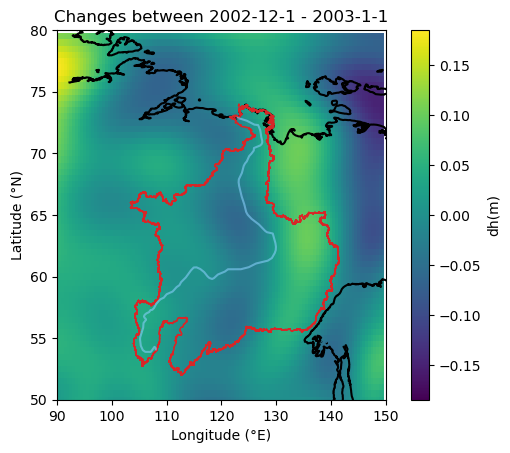

In [21]:
fig, ax = plt.subplots()
i = 6
ds.isel(time=i)["dh(m)"].plot(ax=ax,cmap="viridis")
# ds.isel(time=i).plot(ax=ax,cmap="viridis")
ax.set_title(f"Changes between {grace_names[i]} - {grace_names[i+1]}")
outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,lw=1.5)
ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
bounds = (90.0, 50.0, 150.0, 80.0)
coast.plot(ax=ax,color='k',zorder=1)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));

Mask the dat using [regionmask](https://regionmask.readthedocs.io/en/stable/)

In [22]:
mask = regionmask.mask_geopandas(outline, 
                                 ds.lon.to_numpy(), 
                                 ds.lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [23]:
ds_lena_basin = ds.where(mask==0)

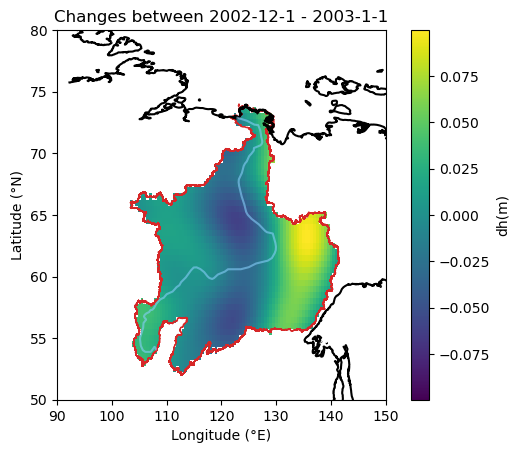

In [24]:
fig, ax = plt.subplots()
# ds_lena_basin.isel(time=i).plot(ax=ax,cmap="viridis")
ds_lena_basin.isel(time=i)["dh(m)"].plot(ax=ax,cmap="viridis")
ax.set_title(f"Changes between {grace_names[i]} - {grace_names[i+1]}")
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,lw=1.5)

bounds = (90.0, 50.0, 150.0, 80.0)
coast.plot(ax=ax,color='k',zorder=1)

ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
## optionally add background but CRS is difficult

# with rasterio.open(get_background_map("outline2", bounds)) as r:
#     rioshow(r, ax=ax,zorder=-10)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));

In [25]:
flat_mask = mask.values.flatten()
masked = len(flat_mask[~np.isnan(flat_mask)])
unmasked = len(flat_mask[np.isnan(flat_mask)])

In [119]:
d_lambda = (_lambda[1] - _lambda[0])
d_theta = (theta[0] - theta[1])
print(f'spatial resolution of a gridcell is {d_lambda*180/np.pi:.2f}deg lon, {d_theta*180/np.pi:.2f}deg lat')
mean_lambda = _lambda.mean()
mean_theta = theta.mean()
print(f'mean value a gridcell is {mean_lambda*180/np.pi:.2f}deg lon, {mean_theta*180/np.pi-90:.2f}deg lat')
distance_1deg_lat = 110.574 # km
distance_1deg_lon = 111.320 * np.cos((mean_theta*180/np.pi-90)*np.pi/180)# km
size_1_grid_cell = distance_1deg_lon * distance_1deg_lat
area_basin = size_1_grid_cell * masked

spatial resolution of a gridcell is 1.00deg lon, 1.00deg lat
mean value a gridcell is 119.50deg lon, -64.50deg lat


Move to a timeseries by integrating over the area: i.e. adding these together

In [27]:
ds_flat = ds_lena_basin.isel(time=0)["dh(m)"].values.flatten()
ds_flat[~np.isnan(ds_flat)].mean() * 1000

13.698165692450184

In [118]:
changes_total_water_mass = ds_lena_basin.mean(dim=["lat","lon"])["dh(m)"] * 100
# fix time indexeing
time_shift = changes_total_water_mass.time.to_numpy()
changes_total_water_mass = changes_total_water_mass[2:-1]
changes_total_water_mass['time'] = time_shift[3:]

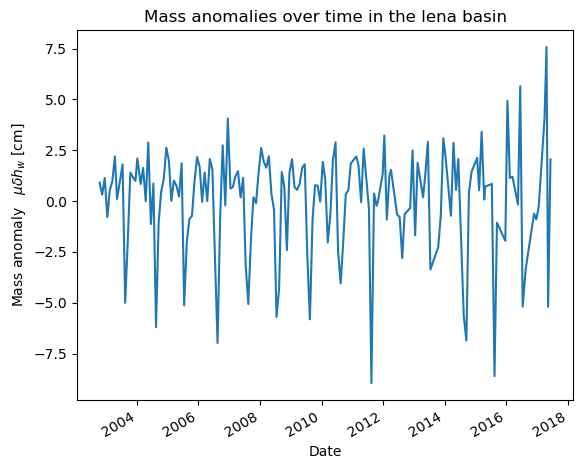

In [105]:
fig, ax = plt.subplots()
changes_total_water_mass.plot(ax=ax,)
ax.set_xlabel("Date")
ax.set_ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
ax.set_title("Mass anomalies over time in the lena basin"); 

Add grace data

In [106]:
def year_to_ts(time):
    ## thanks to https://stackoverflow.com/questions/20911015/decimal-years-to-datetime-in-python
    year = int(time)
    rem = time - year
    base = datetime.datetime(year, 1, 1)
    # result = base + datetime.timedelta(seconds=rem*365.25*24*3600) 
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return result

In [107]:
df = pd.read_csv("Data\\Graceplotter_data_lenabasin.txt",delimiter="\s+",skiprows=463,names=["Time_S","Time_D_1950","Time_y","EWH","Lin","Predic"])
df['EWH'] = df.apply(lambda x: float(x["EWH"]) if x["EWH"] != " NaN" else np.nan,axis=1)
df = df.dropna()

In [108]:
df.index = df['Time_y'].apply(year_to_ts)

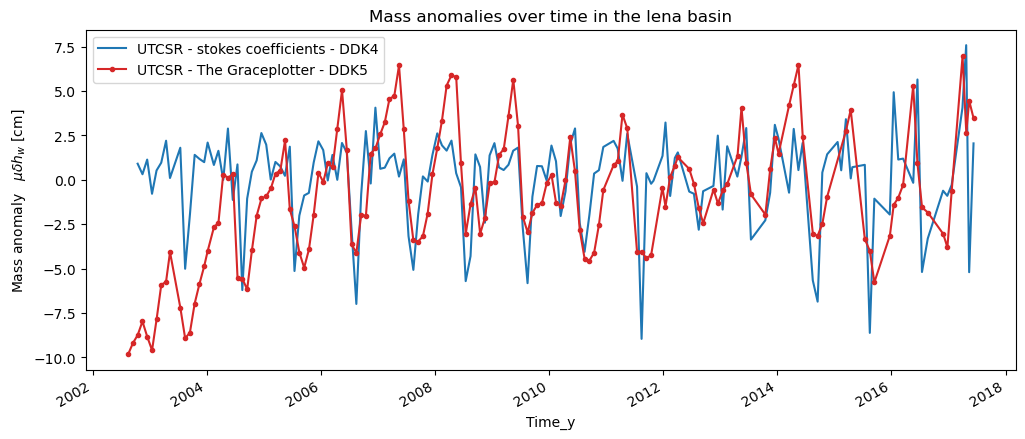

In [111]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(ds.time.to_numpy()[3:], changes_total_water_mass[2:-1],label="shifted")
changes_total_water_mass.plot(ax=ax,label="UTCSR - stokes coefficients - DDK4")
ax.set_xlabel("Date")
ax.set_ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
ax.set_title("Mass anomalies over time in the lena basin"); 

df["EWH"].iloc[2:159].plot(ax=ax,label="UTCSR - The Graceplotter - DDK5",marker=".",color="C3")
ax.legend()

In [35]:
# fig, ax = plt.subplots()
# changes_total_water_mass_km[:130].plot(ax=ax)
# ax.set_xlabel("Date")
# ax.set_ylabel("Mass anomaly   $\sum \delta h_w$ [km^3]")
# ax.set_title("Mass anomalies over time in the lena basin"); 